In [1]:
!pip install tensorflow==2.12.1 opencv-python matplotlib

  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.38.0 requires typing_extensions>=4.6; python_version < "3.12", but you have typing-extensions 4.5.0 which is incompatible.
exceptiongroup 1.3.1 requires typing-extensions>=4.6.0; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#import TensorFlow Dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid out of memory errors by setting GPU memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [24]:
import zipfile

with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [25]:
# Move LFW Images to the following repository data/negative
lfw_path = os.path.join('lfw-deepfunneled', 'lfw-deepfunneled')

for directory in os.listdir(lfw_path):
    for file in os.listdir(os.path.join(lfw_path, directory)):
        EX_PATH = os.path.join(lfw_path, directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [26]:
#import uuid library to generate unique image names
import uuid

In [27]:
#establish connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #crops frame 250x250 in the center kinda
    frame = frame[120:120+250,200:200+250, :]

    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
    
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out positive image
        cv2.imwrite(imgname, frame)
    
    #show image back to screen inside python
    cv2.imshow('Image Collection', frame)

    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

#release webcam and destroys image show frame
cap.release()
cv2.destroyAllWindows()

In [28]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(400)

In [29]:
def preprocess(file_path):
    #read image from file path
    byte_img = tf.io.read_file(file_path)

    #load in the image
    img = tf.io.decode_jpeg(byte_img)

    #preprocess (resize to 100x100x3)
    img = tf.image.resize(img, (100,100))

    #scale image to 0-1
    img = img / 255.0
    return img

In [30]:
# creating labeled dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [31]:
#build test train partition
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [32]:
#build a dataloader pipeline
data = data.map(preprocess_twin, num_parallel_calls=tf.data.AUTOTUNE)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [33]:
#train partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [34]:
#test partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [35]:
def make_embedding():
    inp = Input(shape=(100,100,3), name = 'input_image')

    #first block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)  # CHANGED: was MaxPooling2D(64, (2,2))

    #second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)  # CHANGED: was MaxPooling2D(64, (2,2))

    #third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)  # CHANGED: was MaxPooling2D(64, (2,2))

    #final block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [36]:
embedding = make_embedding()

In [37]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [38]:
#Siamese l1 Distance Class
class L1Dist(Layer):

    #Init method (inheritance)
    def __init__(self, **kwargs):
        super().__init__()

    #rivers combine (similarity calculation)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [39]:
def make_siamese_model():

    #anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    #VALIDATION image input in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    #Combine siamese distance components
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    #Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [40]:
siamese_model = make_siamese_model()

In [41]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [42]:
#Training
#Set up Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [43]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [44]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

In [45]:
@tf.function  # ADD THIS LINE
def train_step(batch):
    with tf.GradientTape() as tape:
        #get anchor and positive/negative image
        X = batch[:2]
        # Get Label
        y = batch[2]
        #Forward Pass
        yhat = siamese_model(X, training=True)
        #Calculate loss
        loss = binary_cross_loss(y, yhat)
    
    #Calculate Gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    #Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    #Return loss
    return loss

In [46]:
#Training Loop
def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #Loop through each batch
        for idx, batch in enumerate(data):
            #run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        #save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [47]:
#train model
EPOCHS = 20

In [49]:
train(train_data, EPOCHS)


 Epoch 1/20
35/35 [==============================] - 67s 2s/step

 Epoch 2/20
35/35 [==============================] - 68s 2s/step

 Epoch 3/20
35/35 [==============================] - 67s 2s/step

 Epoch 4/20
35/35 [==============================] - 69s 2s/step

 Epoch 5/20
35/35 [==============================] - 68s 2s/step

 Epoch 6/20
35/35 [==============================] - 68s 2s/step

 Epoch 7/20
35/35 [==============================] - 67s 2s/step

 Epoch 8/20
35/35 [==============================] - 66s 2s/step

 Epoch 9/20
35/35 [==============================] - 67s 2s/step

 Epoch 10/20
35/35 [==============================] - 69s 2s/step

 Epoch 11/20
35/35 [==============================] - 69s 2s/step

 Epoch 12/20
35/35 [==============================] - 77s 2s/step

 Epoch 13/20
35/35 [==============================] - 68s 2s/step

 Epoch 14/20
35/35 [==============================] - 69s 2s/step

 Epoch 15/20
35/35 [==============================] - 68s 2s/step

 Ep

In [53]:
#import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [55]:
#get batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [57]:
#make predictions
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


In [58]:
#post process the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]

In [59]:
#create metric object
m = Recall()
#calculate recall value
m.update_state(y_true, y_hat)
#return recall resutl
m.result().numpy()

1.0

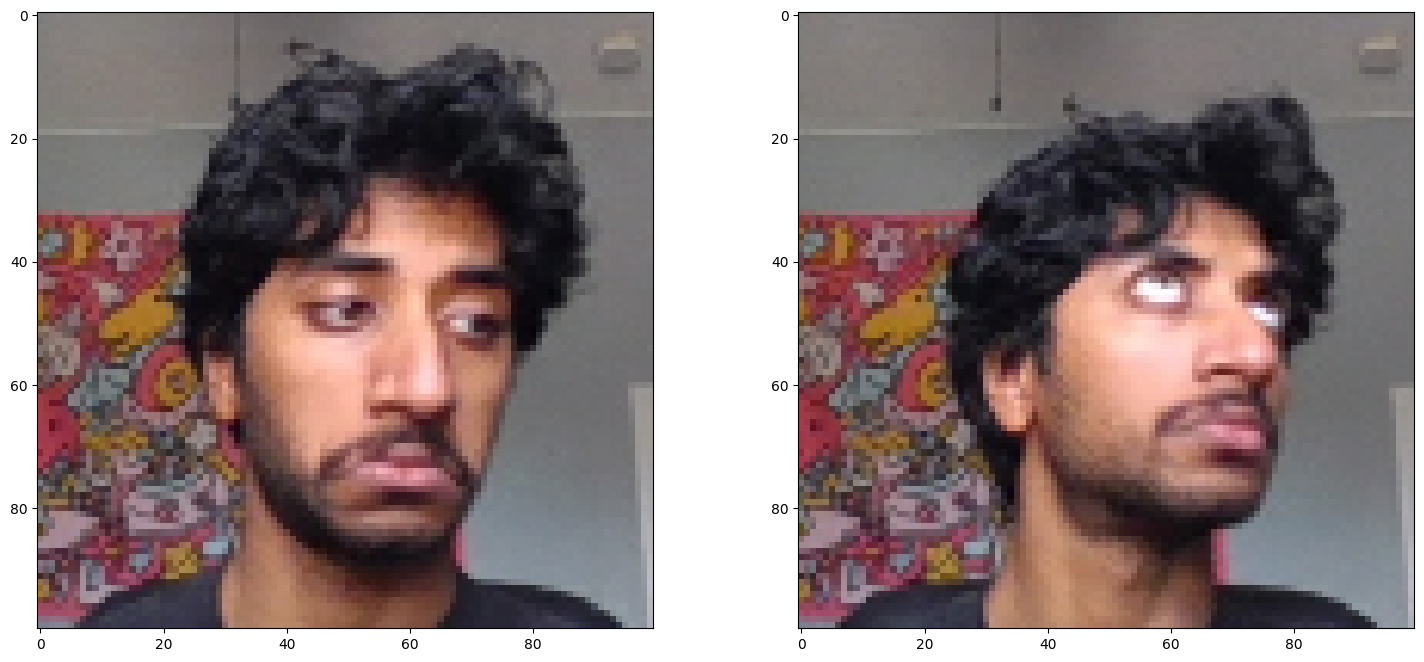

In [64]:
#visulaize results
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[3])
plt.subplot(1,2,2)
plt.imshow(test_val[3])
plt.show()

In [66]:
#save wieghts
siamese_model.save('siamesemodel.h5')

In [68]:
#Reload Model
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects= {'L1Dist':L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [69]:
#make predictions with loaded model
model.predict([test_input, test_val])

1/1 [==============================] - 1s 957ms/step


array([[1.1613675e-07],
       [7.4011560e-08],
       [9.9999964e-01],
       [9.9997699e-01],
       [1.0000000e+00],
       [8.0647887e-06],
       [4.7898883e-08],
       [1.0000000e+00],
       [9.9999958e-01],
       [9.9963301e-01],
       [1.0000000e+00],
       [5.0953194e-08],
       [1.0000000e+00],
       [9.4065580e-12],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [70]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][